# Notebook for finding cumulative annual sum of mean severe hail grid days for US subregions

### Import libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
import statistics
import matplotlib.patheffects as pe

## Import WRF subregional files (switch between regions)

In [2]:
hist = xr.open_dataset('/home/scratch/jgoodin/US_subregions/hist_south_daily_max.nc') #Open hist daily max .nc file saved to /home/scratch directory
mid4p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/mid4p5_south_daily_max.nc') #Open mid-FUTR 4.5 daily max .nc file saved to /home/scratch directory
mid8p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/mid8p5_south_daily_max.nc') #Open mid-FUTR 8.5 daily max .nc file saved to /home/scratch directory
end4p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/end4p5_south_daily_max.nc') #Open end-FUTR 4.5 daily max .nc file saved to /home/scratch directory
end8p5 = xr.open_dataset('/home/scratch/jgoodin/US_subregions/end8p5_south_daily_max.nc') #Open end-FUTR 8.5 daily max .nc file saved to /home/scratch directory

In [3]:
hist #Print out dataset- make sure daily data are returned and lats/lons are correct

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 209, west_east: 278)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 ...

## Pass hail day threshold

In [4]:
hist_sev = 1 * (hist >= 0.0254)
mid4p5_sev = 1 * (mid4p5 >= 0.0254)
mid8p5_sev = 1 * (mid8p5 >= 0.0254) #Convert each WRF grid cell meeting sev hail size threshold to value of 1 to sum hail days
end4p5_sev = 1 * (end4p5 >= 0.0254)
end8p5_sev = 1 * (end8p5 >= 0.0254)

In [5]:
hist_sev #Print out results- number of days should be the same and grid cell values will be either 0 or 1

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 209, west_east: 278)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## For each climate epoch, groupby dayofyear (365 days to plot)

In [6]:
hist_annual = hist_sev.groupby('Time.dayofyear')
mid4p5_annual = mid4p5_sev.groupby('Time.dayofyear')
mid8p5_annual = mid8p5_sev.groupby('Time.dayofyear') #Use xarray's groupby function to group data by days of year
end4p5_annual = end4p5_sev.groupby('Time.dayofyear')
end8p5_annual = end8p5_sev.groupby('Time.dayofyear')

In [7]:
hist_annual #Print out one climate epoch- should return a dataset groupby with labels 1 - 366

DatasetGroupBy, grouped over 'dayofyear'
366 groups with labels 1, 2, 3, 4, 5, ..., 363, 364, 365, 366.

### Take max along 'Time' dim for each climate epoch. Dayofyear array contains values of zeroes and ones (hail days and non-hail days), so we want to take the max value (1) for each grid cell, not the mean, for cumulative sum

In [8]:
hist_max = hist_annual.max(dim = 'Time')
mid4p5_max = mid4p5_annual.max(dim = 'Time')
mid8p5_max = mid8p5_annual.max(dim = 'Time') #Take max along 'Time' dim to single out grid cells that had a hail day (equal to values of 1)
end4p5_max = end4p5_annual.max(dim = 'Time')
end8p5_max = end8p5_annual.max(dim = 'Time')

In [9]:
hist_max #Print out one epich- should contain dayofyear dim x lats x lons

<xarray.Dataset>
Dimensions:     (dayofyear: 366, south_north: 209, west_east: 278)
Coordinates:
  * dayofyear   (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (dayofyear, south_north, west_east) int64 0 0 0 0 0 ... 0 0 0 0

## Compute a cumulative sum along 'dayofyear' dim- provides cumulative sum of grid cells equal to 1 for each day of the year

In [10]:
hist_sum = hist_max.cumsum(dim = 'dayofyear')
mid4p5_sum = mid4p5_max.cumsum(dim = 'dayofyear')
mid8p5_sum = mid8p5_max.cumsum(dim = 'dayofyear') #Use numpy's cumsum function to compute cumulative sum
end4p5_sum = end4p5_max.cumsum(dim = 'dayofyear')
end8p5_sum = end8p5_max.cumsum(dim = 'dayofyear')

In [11]:
hist_sum #Returns array with same shape as input array

<xarray.Dataset>
Dimensions:     (dayofyear: 366, south_north: 209, west_east: 278)
Dimensions without coordinates: dayofyear, south_north, west_east
Data variables:
    HAIL_MAX2D  (dayofyear, south_north, west_east) int64 0 0 0 ... 245 247 245

## Find regional mean by taking mean along lat/lon area of US subregion (south_north and west_east coords)

In [12]:
hist_mean = hist_sum.mean(('south_north', 'west_east'))
mid4p5_mean = mid4p5_sum.mean(('south_north', 'west_east'))
mid8p5_mean = mid8p5_sum.mean(('south_north', 'west_east')) #Take regional mean along south_north and west_east dims (lat/lon area)
end4p5_mean = end4p5_sum.mean(('south_north', 'west_east'))
end8p5_mean = end8p5_sum.mean(('south_north', 'west_east'))

In [13]:
end8p5_mean #Print out one epoch- returns annual cum. sum 

<xarray.Dataset>
Dimensions:     (dayofyear: 366)
Dimensions without coordinates: dayofyear
Data variables:
    HAIL_MAX2D  (dayofyear) float64 0.7575 1.733 2.521 ... 252.7 253.5 253.5

## Divide regional mean by 15 (# of years in each epoch) to find cumulative annual sum

In [14]:
hist_avg = hist_mean / 15
mid4p5_avg = mid4p5_mean / 15
mid8p5_avg = mid8p5_mean / 15 #Divide each regional mean by # of years to find annual statistic
end4p5_avg = end4p5_mean / 15 # **These are plotting variables**
end8p5_avg = end8p5_mean / 15

In [15]:
end8p5_avg.HAIL_MAX2D.max() #Can check max/mean from each epoch to make sure numbers seem correct

<xarray.DataArray 'HAIL_MAX2D' ()>
array(16.90029718)

## Find 25th and 75th percentiles for each climate epoch for each month to plot along with means

### Find raw 25th percentiles for each day

In [16]:
hist_lower = np.percentile(hist_sum.HAIL_MAX2D.values, 25, axis = (1, 2))
mid4p5_lower = np.percentile(mid4p5_sum.HAIL_MAX2D.values, 25, axis = (1, 2))
mid8p5_lower = np.percentile(mid8p5_sum.HAIL_MAX2D.values, 25, axis = (1, 2)) #Muss pass 'axis' argument to percentile function to calculate percentiles across lats/lons
end4p5_lower = np.percentile(end4p5_sum.HAIL_MAX2D.values, 25, axis = (1, 2)) # (axes 1 and 2 respectively)
end8p5_lower = np.percentile(end8p5_sum.HAIL_MAX2D.values, 25, axis = (1, 2))

In [17]:
hist_lower.shape #Make sure array is one-dimensional

(366,)

### Divide each values by 15 to get annual percentiles

In [18]:
hist_lower_annual = hist_lower / 15
mid4p5_lower_annual = mid4p5_lower / 15
mid8p5_lower_annual = mid8p5_lower / 15 #Divide each percentile value in array by 15 to get annual statistic
end4p5_lower_annual = end4p5_lower / 15 # **These are plotting variables for fill_between plot**
end8p5_lower_annual = end8p5_lower / 15

In [19]:
end8p5_lower_annual.max() #Make sure 366 values are still returned

16.2

### Find 75th percentiles for each day repeating same process as above

In [20]:
hist_upper = np.percentile(hist_sum.HAIL_MAX2D.values, 75, axis = (1, 2))
mid4p5_upper = np.percentile(mid4p5_sum.HAIL_MAX2D.values, 75, axis = (1, 2))
mid8p5_upper = np.percentile(mid8p5_sum.HAIL_MAX2D.values, 75, axis = (1, 2))
end4p5_upper = np.percentile(end4p5_sum.HAIL_MAX2D.values, 75, axis = (1, 2))
end8p5_upper = np.percentile(end8p5_sum.HAIL_MAX2D.values, 75, axis = (1, 2))

In [21]:
hist_upper.shape

(366,)

### Divide by 15 for annual percentiles

In [22]:
hist_upper_annual = hist_upper / 15
mid4p5_upper_annual = mid4p5_upper / 15
mid8p5_upper_annual = mid8p5_upper / 15 #Divide each percentile value in array by 15 to get annual statistic
end4p5_upper_annual = end4p5_upper / 15 # **These are plotting variables for fill_between plot**
end8p5_upper_annual = end8p5_upper / 15

In [23]:
end8p5_upper_annual.max() #Can check max/min/shape to make sure numbers/array shape are correct

17.666666666666668

## Plot daily means, percentiles for each US region

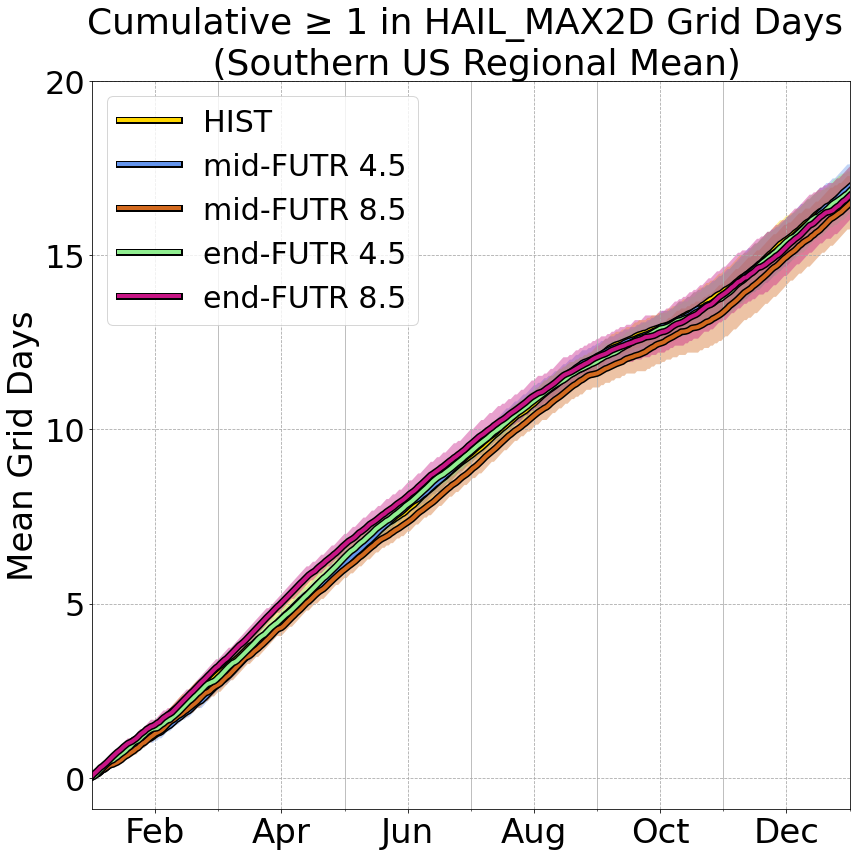

In [25]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(figsize = (12, 12))

plt.plot(hist_avg.HAIL_MAX2D, color = 'gold', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "HIST")
ax.fill_between(np.arange(0, 366, 1), hist_lower_annual, hist_upper_annual, alpha = 0.4, facecolor = 'gold') #Plot percentiles using fill_between
#plt.plot(hist_lower_annual, color = 'k', linewidth = 4) #Test plot one percentile
                 
plt.plot(mid4p5_avg.HAIL_MAX2D, color = 'cornflowerblue', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "mid-FUTR 4.5")
ax.fill_between(np.arange(0, 366, 1), mid4p5_lower_annual, mid4p5_upper_annual, alpha = 0.4, facecolor = 'cornflowerblue') #Plot percentiles using fill_between

plt.plot(mid8p5_avg.HAIL_MAX2D, color = 'chocolate', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "mid-FUTR 8.5")
ax.fill_between(np.arange(0, 366, 1), mid8p5_lower_annual, mid8p5_upper_annual, alpha = 0.4, facecolor = 'chocolate') #Plot percentiles using fill_between

plt.plot(end4p5_avg.HAIL_MAX2D, color = 'lightgreen', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "end-FUTR 4.5")
ax.fill_between(np.arange(0, 366, 1), end4p5_lower_annual, end4p5_upper_annual, alpha = 0.4, facecolor = 'lightgreen') #Plot percentiles using fill_between

plt.plot(end8p5_avg.HAIL_MAX2D, color = 'mediumvioletred', linewidth = 4, path_effects=[pe.Stroke(linewidth=7, foreground='k'), pe.Normal()], label = "end-FUTR 8.5")
ax.fill_between(np.arange(0, 366, 1), end8p5_lower_annual, end8p5_upper_annual, alpha = 0.4, facecolor = 'mediumvioletred') #Plot percentiles using fill_between

plt.grid(color = 'darkgray', linestyle = '--')
ax.set_title('Cumulative ≥ 1 in HAIL_MAX2D Grid Days \n (Southern US Regional Mean)', fontsize = 36)
#ax.set_yticks([(10**0), (10**1), (10**2), (10**3), (10**4), (10**5), (10**6), (10**7), (10**8)])
ax.set_yticks([0, 5, 10, 15, 20])
plt.xlim(0, 360)
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
plt.xticks([30, 90, 150, 210, 270, 330], ["Feb", "Apr", "Jun", "Aug", "Oct", "Dec"], fontsize = 34)
plt.yticks(fontsize = 32)
ax.set_ylabel('Mean Grid Days', fontsize = 34)
plt.legend(fontsize=30, loc='upper left')
plt.tight_layout()
#plt.savefig('/home/scratch/jgoodin/midwest_cum_sev_hail_days.png')
plt.show()

# Create box and whisker plots of cumulative hail days

## Make data 1D

In [26]:
hist_1d = hist_avg.HAIL_MAX2D.values.ravel() 
mid4p5_1d = mid4p5_avg.HAIL_MAX2D.values.ravel()
mid8p5_1d = mid8p5_avg.HAIL_MAX2D.values.ravel() #Use numpy's ravel method to return a contiguous flattened 1D array
end4p5_1d = end4p5_avg.HAIL_MAX2D.values.ravel()
end8p5_1d = end8p5_avg.HAIL_MAX2D.values.ravel()

In [27]:
len(hist_1d) #Check how many values are being returned by the 1D array- should be 366

366

## Remove all values from array ≠ 0

In [28]:
hist_nonzero = hist_1d[hist_1d != 0]
mid4p5_nonzero = mid4p5_1d[mid4p5_1d != 0]
mid8p5_nonzero = mid8p5_1d[mid8p5_1d != 0] #Select all values from climate epoch (change variables) that are ≠ 0
end4p5_nonzero = end4p5_1d[end4p5_1d != 0] 
end8p5_nonzero = end8p5_1d[end8p5_1d != 0]

#Combine each array into one variable for plotting purposes

data = [hist_nonzero, mid4p5_nonzero, mid8p5_nonzero, end4p5_nonzero, end8p5_nonzero]

In [29]:
min(hist_nonzero)

0.033584615561139605

/tmp/ipykernel_9058/2476058950.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


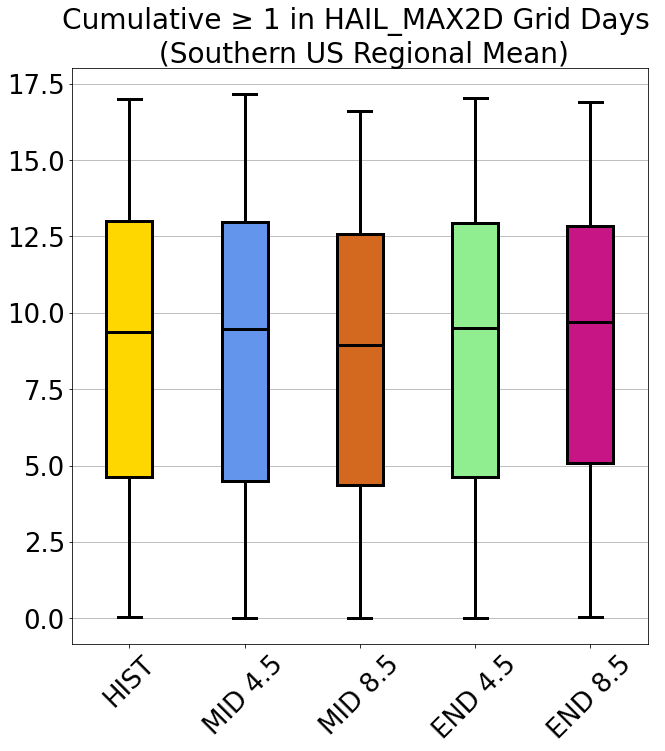

In [32]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_axes([0, 0, 1, 1])

mp = dict(linewidth = 3, color = 'black')
wp = dict(linewidth = 3, color = 'black')
cp = dict(linewidth = 3, color = 'black')

d0 = plt.boxplot(data[0], patch_artist = True, manage_ticks = True, positions = [1], widths = 0.4, medianprops = mp, whiskerprops = wp, capprops = cp)
d1 = plt.boxplot(data[1], patch_artist = True, manage_ticks = True, positions = [2], widths = 0.4, medianprops = mp, whiskerprops = wp, capprops = cp)
d2 = plt.boxplot(data[2], patch_artist = True, manage_ticks = True, positions = [3], widths = 0.4, medianprops = mp, whiskerprops = wp, capprops = cp)
d3 = plt.boxplot(data[3], patch_artist = True, manage_ticks = True, positions = [4], widths = 0.4, medianprops = mp, whiskerprops = wp, capprops = cp)
d4 = plt.boxplot(data[4], patch_artist = True, manage_ticks = True, positions = [5], widths = 0.4, medianprops = mp, whiskerprops = wp, capprops = cp)

for box in d0['boxes']:
    box.set(color = 'black', linewidth = 3)
    box.set(facecolor = 'gold')

for box in d1['boxes']:
    box.set(color = 'black', linewidth = 3)
    box.set(facecolor = 'cornflowerblue')
    
for box in d2['boxes']:
    box.set(color = 'black', linewidth = 3)
    box.set(facecolor = 'chocolate')
    
for box in d3['boxes']:
    box.set(color = 'black', linewidth = 3)
    box.set(facecolor = 'lightgreen')
    
for box in d4['boxes']:
    box.set(color = 'black', linewidth = 3)
    box.set(facecolor = 'mediumvioletred')
    
plt.xticks([1, 2, 3, 4, 5], ["HIST", "MID 4.5", "MID 8.5", "END 4.5", "END 8.5"], fontsize = 26, rotation = 45)
ax.set_yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5])
plt.yticks(fontsize = 26)
plt.title('Cumulative ≥ 1 in HAIL_MAX2D Grid Days \n (Southern US Regional Mean)', fontsize = 28)
plt.grid(axis = 'y')
plt.tight_layout()
plt.savefig('/home/scratch/jgoodin/south_cum_sev_hail_days_boxwhisker.png', bbox_inches="tight")
plt.show()